**Mobile Gaming User Retention - A/B Testing**

**Introduction**
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats!

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this analysis, we're going to analyze an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
# Step 1: Load the dataset
df = pd.read_csv('cookie_cats.csv')
# Step 2: Basic Data Exploration
print("Dataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Overview:
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None

Descriptive Statistics:
             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06     

The data we have is from 90,189 players that installed the game while the A/B-test was running. The variables are:

userid - a unique number that identifies each player.
version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
retention_1 - did the player come back and play 1 day after installing?
retention_7 - did the player come back and play 7 days after installing?
When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. As a sanity check, let's see if there are roughly the same number of players in each A/B group.

In [4]:
# Step 3: Group by version and calculate key metrics
grouped = df.groupby('version').agg({
    'userid': 'count',
    'sum_gamerounds': 'mean',
    'retention_1': 'mean',  # Proportion of TRUE (1)
    'retention_7': 'mean'   # Proportion of TRUE (1)
}).rename(columns={
    'userid': 'total_players',
    'sum_gamerounds': 'avg_game_rounds',
    'retention_1': 'retention_1_rate',
    'retention_7': 'retention_7_rate'
})
print("\nGroup Summary:")
print(grouped)



Group Summary:
         total_players  avg_game_rounds  retention_1_rate  retention_7_rate
version                                                                    
gate_30          44700        52.456264          0.448188          0.190201
gate_40          45489        51.298776          0.442283          0.182000


It looks like there is roughly the same number of players in each group, nice!

The focus of this analysis will be on how the gate placement affects player retention, but first I'll plot the distribution of the number of game rounds players played during their first week playing the game.

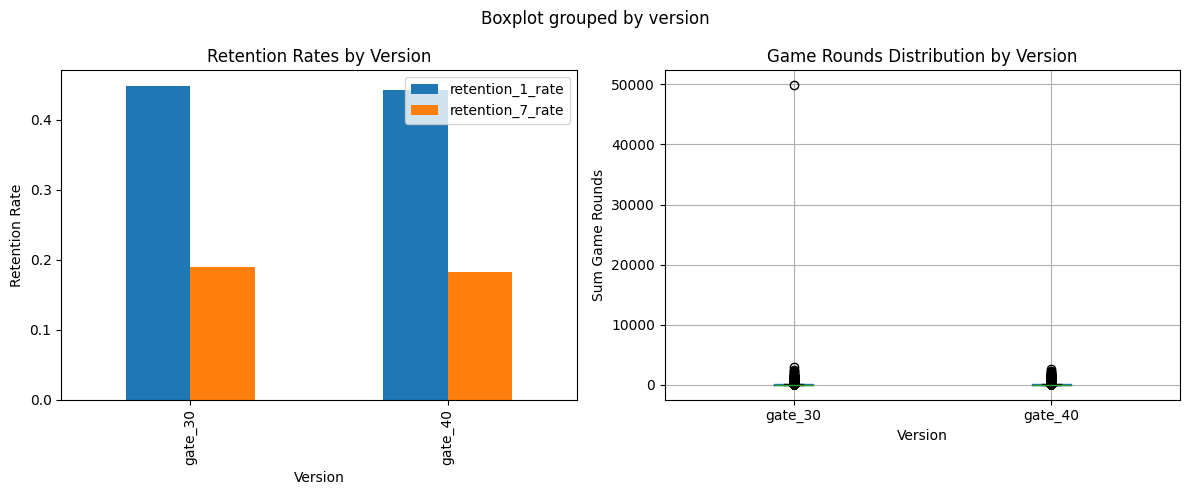

In [5]:
# Step 4: Visualize distributions (optional, simple plots)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Retention rates bar plot
grouped[['retention_1_rate', 'retention_7_rate']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Retention Rates by Version')
axes[0].set_ylabel('Retention Rate')
axes[0].set_xlabel('Version')
# Game rounds box plot
df.boxplot(column='sum_gamerounds', by='version', ax=axes[1])
axes[1].set_title('Game Rounds Distribution by Version')
axes[1].set_ylabel('Sum Game Rounds')
axes[1].set_xlabel('Version')
plt.tight_layout()
plt.show()

**1-Day Retention**

In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!

What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that come back and play the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day retention is overall.

In [6]:
# Overall 1-day retention
overall_retention_1 = df['retention_1'].mean() * 100
print(f"Overall 1-day retention: {overall_retention_1:.2f}%")

Overall 1-day retention: 44.52%


So, a little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two A/B-groups.

In [7]:
# 1-day retention by version
retention_1_by_version = df[['retention_1', 'version']].groupby('version').mean() * 100
print(retention_1_by_version)

         retention_1
version             
gate_30    44.818792
gate_40    44.228275


It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here I will use bootstrapping: I will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

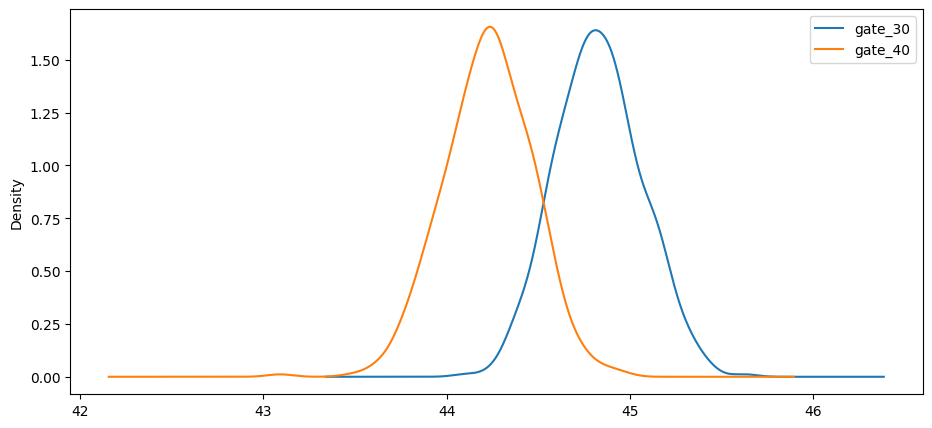

In [8]:
# Bootstrap for 1-day retention
boot_1d = []
for i in range(500):
    boot_mean = df[['retention_1', 'version']].sample(frac=1, replace=True).groupby('version').mean() * 100
    boot_1d.append(boot_mean)

boot_1d_df = pd.DataFrame([[boot_1d[i].values[0,0], boot_1d[i].values[1,0]] for i in range(500)], columns=['gate_30','gate_40'])

# Kernel Density Estimate plot of the bootstrap distributions
boot_1d_df.plot.kde(figsize=(11,5))
plt.show()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two A/B-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention.

(Note that in this notebook I have limited the number of bootstrap replications to 500 to keep the calculations quick. In "production" one would likely increase this to a much larger number, say, 10,000.)

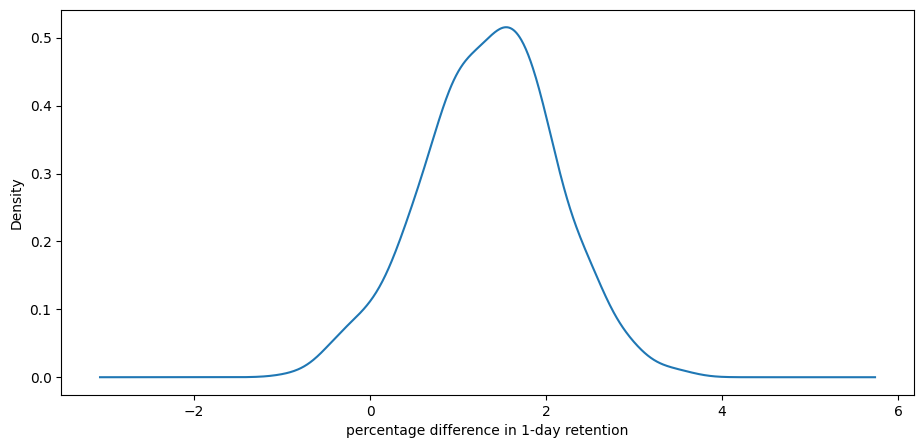

In [13]:
# Calculate percentage difference
boot_1d_df['diff'] = (boot_1d_df['gate_30'] - boot_1d_df['gate_40']) / boot_1d_df['gate_40'] * 100

# Plot the bootstrap % difference
ax = boot_1d_df['diff'].plot.kde(figsize=(11, 5))
ax.set_xlabel("percentage difference in 1-day retention")
plt.show()

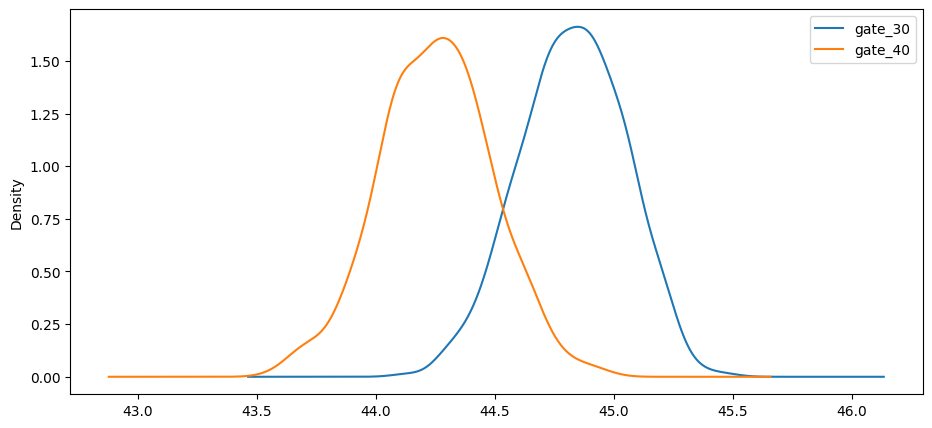

In [14]:
# Bootstrap for 1-day retention
boot_1d = []
for i in range(500):
    boot_mean = df[['retention_1', 'version']].sample(frac=1, replace=True).groupby('version').mean() * 100
    boot_1d.append(boot_mean)

boot_1d_df = pd.DataFrame([[boot_1d[i].values[0,0], boot_1d[i].values[1,0]] for i in range(500)], columns=['gate_30','gate_40'])

# Kernel Density Estimate plot of the bootstrap distributions
boot_1d_df.plot.kde(figsize=(11,5))
plt.show()

From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? I'll calculate that as well.

In [16]:
boot_1d_df['diff'] = (boot_1d_df['gate_30'] - boot_1d_df['gate_40']) / boot_1d_df['gate_40'] * 100
# Probability that difference > 0
prob = (boot_1d_df['diff'] > 0.0).mean()
print(f"Probability that gate_30 has higher 1-day retention: {prob * 100:.2f}%")

Probability that gate_30 has higher 1-day retention: 97.00%


**7-Day Retention**

The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

I'll start by calculating 7-day retention for the two A/B-groups.

In [17]:
# 7-day retention by version
retention_7_by_version = df[['retention_7', 'version']].groupby('version').mean() * 100
print(retention_7_by_version)

         retention_7
version             
gate_30    19.020134
gate_40    18.200004


Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the A/B-groups.

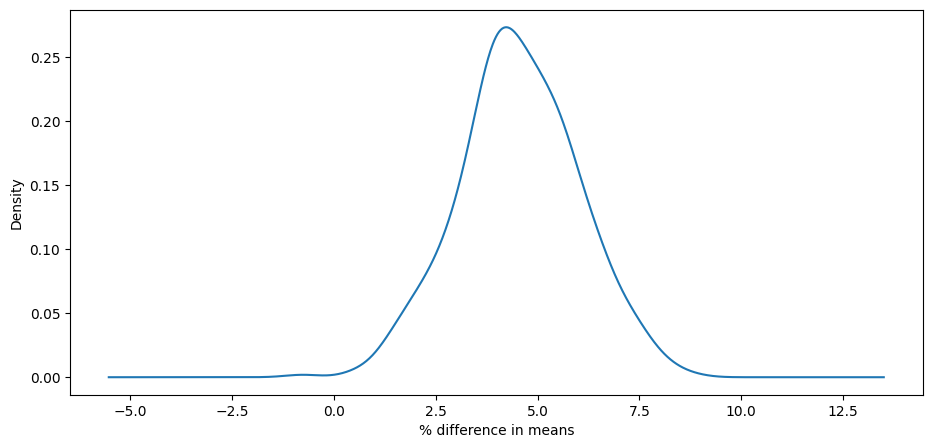

Probability that gate_30 has higher 7-day retention: 99.80%


In [18]:
# Bootstrap for 7-day retention
boot_7d = []
for i in range(500):
    boot_mean = df[['retention_7', 'version']].sample(frac=1, replace=True).groupby('version').mean() * 100
    boot_7d.append(boot_mean)

boot_7d_df = pd.DataFrame([[boot_7d[i].values[0,0], boot_7d[i].values[1,0]] for i in range(500)], columns=['gate_30','gate_40'])

boot_7d_df['diff'] = (boot_7d_df['gate_30'] - boot_7d_df['gate_40']) / boot_7d_df['gate_40'] * 100

ax = boot_7d_df['diff'].plot.kde(figsize=(11, 5))
ax.set_xlabel("% difference in means")
plt.show()

prob_7d = (boot_7d_df['diff'] > 0.0).mean()
print(f"Probability that gate_30 has higher 7-day retention: {prob_7d * 100:.2f}%")

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two A/B-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.

In [19]:
#Export summary for Power BI

summary = df.groupby('version').agg({
    'userid': 'count',
    'sum_gamerounds': ['mean', 'median'],
    'retention_1': 'mean',
    'retention_7': 'mean'
}).round(4)

summary.columns = ['total_players', 'avg_game_rounds', 'median_game_rounds', 'retention_1_rate', 'retention_7_rate']
summary.reset_index(inplace=True)

# Add bootstrap difference results
summary['bootstrap_day1_diff_%'] = boot_1d_df['gate_30'].mean() - boot_1d_df['gate_40'].mean()
summary['bootstrap_day7_diff_%'] = boot_7d_df['gate_30'].mean() - boot_7d_df['gate_40'].mean()

print("\nSummary for Power BI:")
print(summary)

# ✅ Save as CSV for Power BI
summary.to_csv("cookie_cats_summary.csv", index=False)
df.to_csv("cookie_cats_clean.csv", index=False)
print("\n✅ Files saved: 'cookie_cats_summary.csv' and 'cookie_cats_clean.csv'")



Summary for Power BI:
   version  total_players  avg_game_rounds  median_game_rounds  \
0  gate_30          44700          52.4563                17.0   
1  gate_40          45489          51.2988                16.0   

   retention_1_rate  retention_7_rate  bootstrap_day1_diff_%  \
0            0.4482            0.1902               0.574044   
1            0.4423            0.1820               0.574044   

   bootstrap_day7_diff_%  
0                0.82332  
1                0.82332  

✅ Files saved: 'cookie_cats_summary.csv' and 'cookie_cats_clean.csv'


In [20]:
# Probability that gate_30 has higher retention than gate_40
prob_1_higher = (boot_1d_df['gate_30'] > boot_1d_df['gate_40']).mean()
prob_7_higher = (boot_7d_df['gate_30'] > boot_7d_df['gate_40']).mean()

# Create a small table
prob_df = pd.DataFrame({
    'Retention_Period': ['Day-1', 'Day-7'],
    'Probability_Gate30_Higher': [prob_1_higher, prob_7_higher]
})

prob_df.to_csv("probability_data.csv", index=False)

In [21]:
summary = df.groupby('version')[['retention_1','retention_7','sum_gamerounds']].mean()
summary.reset_index(inplace=True)
summary.to_csv("cookie_cats_summary.csv", index=False)